# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
new_transactions = pd.read_csv('data\\new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('data\\historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [4]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________

train = read_data('data\\train.csv')
test = read_data('data\\test.csv')

target = train['target']
del train['target']

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [5]:
bins = historical_transactions.groupby(['city_id',])['merchant_id'].nunique()

In [6]:
def bfunc(x):
    for pair in [(10000,1),(7000,2),(4000,3),(1000,4),(700,5),(300,6),(0,7)]:
        if x > pair[0]:
            return pair[1]
        
reps = {x:bfunc(y) for x,y in bins.iteritems()}
reps[-1] = 10

In [7]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [8]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,10
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,10
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,10
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,10
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,10


In [9]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [10]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month


In [11]:
def new_dcats(dt):
    dt['month_purchase_end'] = dt['purchase_date'].dt.is_month_end
    dt['month_purchase_start'] = dt['purchase_date'].dt.is_month_start
    dt['purchase_week_day'] = dt['purchase_date'].dt.weekday > 5
    return dt

historical_transactions = new_dcats(historical_transactions)
authorized_transactions = new_dcats(authorized_transactions)
new_transactions = new_dcats(new_transactions)

In [16]:
#replaced 
historical_transactions['city_bins'] = historical_transactions.city_id.replace(reps)
authorized_transactions['city_bins'] = authorized_transactions.city_id.replace(reps)
new_transactions['city_bins'] = new_transactions.city_id.replace(reps)

In [18]:
historical_transactions.city_bins

115          3
132          3
148          3
168          1
213          3
294          3
306          3
365          3
368          3
400          4
407          7
410          5
414          4
438          3
455          1
465          4
467          3
481          3
493          1
496          4
505          3
508          3
517          3
522          4
562          4
566          4
599          4
615          4
630          3
631          4
            ..
29111862     4
29111880     3
29111890     3
29111931     6
29111954     2
29111955     2
29111976     6
29112004     6
29112011     1
29112026     6
29112043    10
29112047    10
29112063    10
29112067     5
29112079     4
29112098     3
29112115    10
29112130     4
29112142     6
29112187    10
29112191    10
29112195     4
29112199     4
29112200     4
29112201     4
29112210     3
29112213     3
29112230    10
29112306    10
29112313     1
Name: city_bins, Length: 2516909, dtype: int64

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [19]:
def modeplus(x):
    return mode(x)[0]

In [20]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique','median'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean'],
    'month_purchase_end': ['mean','median'],
    'month_purchase_start': ['mean','median'],
    'purchase_week_day': ['mean'],
    'city_bins': [modeplus]
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [21]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_city_id_median,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,hist_month_purchase_end_mean,hist_month_purchase_end_median,hist_month_purchase_start_mean,hist_month_purchase_start_median,hist_purchase_week_day_mean,hist_city_bins_modeplus
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,244.0,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.857143,0.028571,0.0,0.028571,0.0,0.000000,4
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,149.0,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.333333,0.000000,0.0,0.000000,0.0,0.000000,3
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,137.0,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,10.000000,0.000000,0.0,0.000000,0.0,0.250000,3
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,179.0,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.888889,0.000000,0.0,0.000000,0.0,0.037037,4
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,161.0,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.571429,0.428571,0.0,0.000000,0.0,0.000000,4


In [22]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_city_id_median,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,auth_month_purchase_end_mean,auth_month_purchase_end_median,auth_month_purchase_start_mean,auth_month_purchase_start_median,auth_purchase_week_day_mean,auth_city_bins_modeplus
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,244.0,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.833333,0.017544,0.0,0.078947,0.0,0.035088,4
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,314.0,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.866667,0.000000,0.0,0.008333,0.0,0.150000,4
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,137.0,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.951613,0.016129,0.0,0.016129,0.0,0.048387,3
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,179.0,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.878307,0.015873,0.0,0.031746,0.0,0.015873,4
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,161.0,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.817518,0.043796,0.0,0.094891,0.0,0.087591,4


In [23]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_city_id_median,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,new_month_purchase_end_mean,new_month_purchase_end_median,new_month_purchase_start_mean,new_month_purchase_start_median,new_purchase_week_day_mean,new_city_bins_modeplus
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,72.5,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,1
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,291.0,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.807692,0.038462,0.0,0.076923,0.0,0.192308,4
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,137.0,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,10.000000,0.000000,0.0,0.000000,0.0,0.000000,3
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,87.0,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.419355,0.129032,0.0,0.000000,0.0,0.322581,1
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,161.0,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.727273,0.090909,0.0,0.000000,0.0,0.000000,4


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [25]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

#___________________________________________________________

final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_modeplus_mean,purchase_amount_modeplus_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_modeplus_mean,installments_modeplus_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.677150,0.076448,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.0,0.0,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.678540,0.062160,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,1.0,0.0,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.596811,0.170438,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.675812,0.064374,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,1.0,0.0,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,1.0,0.0,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [27]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')


<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [28]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [ ]:
# cols = [c for c in train if c.startswith('hist')]
# train.loc[train['hist_transactions_count'].isnull(), cols] = 0
# test.loc[test['hist_transactions_count'].isnull(), cols] = 0

# cols = [c for c in train if c.startswith('new')]
# train.loc[train['new_transactions_count'].isnull(), cols] = 0
# test.loc[test['new_transactions_count'].isnull(), cols] = 0

In [ ]:
# cols = [c for c in train if c.endswith('std')]
# for c in cols:
#     train.loc[train[c].isnull(), c] = 0
#     test.loc[test[c].isnull(), c] = 0

In [ ]:
# train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
# test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

In [ ]:
# hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
# for c in hist_columns:
#     col_name = 'ratio_{}_{}'.format(c[0], c[1])
#     train[col_name] = train[c[0]] / train[c[1]]
#     test[col_name] = test[c[0]] / test[c[1]]

In [29]:
test.to_csv('test.csv')
train['target'] = target
train.to_csv('train.csv')
del train['target']

and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

In [30]:
# unimportant_features = [
#     'auth_category_2_1.0_mean',
#     'auth_category_2_2.0_mean',
#     'auth_category_2_3.0_mean',
#     'auth_category_2_5.0_mean',
#     'hist_category_2_3.0_mean',
#     'hist_category_2_4.0_mean',
#     'hist_category_2_5.0_mean',
#     'hist_category_3_A_mean',
#     'hist_installments_min',
#     'hist_installments_std',
#     'hist_month_lag_std',
#     'hist_purchase_amount_max',
#     'hist_purchase_month_max',
#     'hist_purchase_month_min',
#     'hist_purchase_month_std',
#     'installments_min_mean',
#     'new_category_2_1.0_mean',
#     'new_category_2_2.0_mean',
#     'new_category_2_3.0_mean',
#     'new_category_2_5.0_mean',
#     'new_city_id_nunique',
#     'new_installments_std',
#     'new_state_id_nunique',
#     'purchase_amount_mean_mean'
# ]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [31]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [32]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7141	valid_1's rmse: 3.77664
[200]	training's rmse: 3.64466	valid_1's rmse: 3.7299
[300]	training's rmse: 3.60142	valid_1's rmse: 3.70657
[400]	training's rmse: 3.57003	valid_1's rmse: 3.69375
[500]	training's rmse: 3.54622	valid_1's rmse: 3.68651
[600]	training's rmse: 3.52686	valid_1's rmse: 3.68198
[700]	training's rmse: 3.51078	valid_1's rmse: 3.67895
[800]	training's rmse: 3.49623	valid_1's rmse: 3.67737
[900]	training's rmse: 3.4831	valid_1's rmse: 3.67606
[1000]	training's rmse: 3.47131	valid_1's rmse: 3.67518
[1100]	training's rmse: 3.45896	valid_1's rmse: 3.67471
[1200]	training's rmse: 3.44679	valid_1's rmse: 3.67397
[1300]	training's rmse: 3.43576	valid_1's rmse: 3.67365
[1400]	training's rmse: 3.42486	valid_1's rmse: 3.67356
[1500]	training's rmse: 3.41434	valid_1's rmse: 3.67325
[1600]	training's rmse: 3.40409	valid_1's rmse: 3.67325
[1700]	training's rmse: 3.39406	valid_1's rmse: 3.673

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73141	valid_1's rmse: 3.70548
[200]	training's rmse: 3.66097	valid_1's rmse: 3.66102
[300]	training's rmse: 3.61652	valid_1's rmse: 3.64051
[400]	training's rmse: 3.58465	valid_1's rmse: 3.6298
[500]	training's rmse: 3.56005	valid_1's rmse: 3.62416
[600]	training's rmse: 3.54022	valid_1's rmse: 3.62083
[700]	training's rmse: 3.52392	valid_1's rmse: 3.61831
[800]	training's rmse: 3.50818	valid_1's rmse: 3.61674
[900]	training's rmse: 3.49537	valid_1's rmse: 3.61561
[1000]	training's rmse: 3.48369	valid_1's rmse: 3.61487
[1100]	training's rmse: 3.47159	valid_1's rmse: 3.61433
[1200]	training's rmse: 3.45918	valid_1's rmse: 3.61366
[1300]	training's rmse: 3.44769	valid_1's rmse: 3.61308
[1400]	training's rmse: 3.43671	valid_1's rmse: 3.61312
[1500]	training's rmse: 3.42575	valid_1's rmse: 3.61313
[1600]	training's rmse: 3.41547	valid_1's rmse: 3.61316
Early stopping, best iteration is:
[1465]	training'

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7354	valid_1's rmse: 3.68117
[200]	training's rmse: 3.66403	valid_1's rmse: 3.63977
[300]	training's rmse: 3.61919	valid_1's rmse: 3.6216
[400]	training's rmse: 3.58625	valid_1's rmse: 3.61168
[500]	training's rmse: 3.56115	valid_1's rmse: 3.60638
[600]	training's rmse: 3.54122	valid_1's rmse: 3.60283
[700]	training's rmse: 3.52405	valid_1's rmse: 3.60047
[800]	training's rmse: 3.50975	valid_1's rmse: 3.59908
[900]	training's rmse: 3.49644	valid_1's rmse: 3.59807
[1000]	training's rmse: 3.48315	valid_1's rmse: 3.59746
[1100]	training's rmse: 3.47074	valid_1's rmse: 3.59711
[1200]	training's rmse: 3.45904	valid_1's rmse: 3.59682
[1300]	training's rmse: 3.44814	valid_1's rmse: 3.59683
[1400]	training's rmse: 3.4361	valid_1's rmse: 3.59665
[1500]	training's rmse: 3.42503	valid_1's rmse: 3.59684
Early stopping, best iteration is:
[1387]	training's rmse: 3.43784	valid_1's rmse: 3.59659
fold n°3


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68711	valid_1's rmse: 3.87914
[200]	training's rmse: 3.6172	valid_1's rmse: 3.83175
[300]	training's rmse: 3.57268	valid_1's rmse: 3.80937
[400]	training's rmse: 3.54097	valid_1's rmse: 3.79753
[500]	training's rmse: 3.51602	valid_1's rmse: 3.79114
[600]	training's rmse: 3.49677	valid_1's rmse: 3.78748
[700]	training's rmse: 3.47952	valid_1's rmse: 3.78491
[800]	training's rmse: 3.46525	valid_1's rmse: 3.78382
[900]	training's rmse: 3.45194	valid_1's rmse: 3.78287
[1000]	training's rmse: 3.43902	valid_1's rmse: 3.78225
[1100]	training's rmse: 3.42606	valid_1's rmse: 3.78194
[1200]	training's rmse: 3.41345	valid_1's rmse: 3.78185
[1300]	training's rmse: 3.40209	valid_1's rmse: 3.78137
[1400]	training's rmse: 3.39052	valid_1's rmse: 3.78125
[1500]	training's rmse: 3.3796	valid_1's rmse: 3.78127
Early stopping, best iteration is:
[1397]	training's rmse: 3.39079	valid_1's rmse: 3.78122
fold n°4


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73255	valid_1's rmse: 3.69416
[200]	training's rmse: 3.66042	valid_1's rmse: 3.65282
[300]	training's rmse: 3.61536	valid_1's rmse: 3.63455
[400]	training's rmse: 3.58389	valid_1's rmse: 3.62535
[500]	training's rmse: 3.55985	valid_1's rmse: 3.61992
[600]	training's rmse: 3.54056	valid_1's rmse: 3.61705
[700]	training's rmse: 3.5243	valid_1's rmse: 3.61538
[800]	training's rmse: 3.509	valid_1's rmse: 3.61426
[900]	training's rmse: 3.49577	valid_1's rmse: 3.6135
[1000]	training's rmse: 3.48253	valid_1's rmse: 3.61281
[1100]	training's rmse: 3.47002	valid_1's rmse: 3.6126
[1200]	training's rmse: 3.45734	valid_1's rmse: 3.61277
Early stopping, best iteration is:
[1075]	training's rmse: 3.47317	valid_1's rmse: 3.61255
CV score: 3.65591 


<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

In [38]:
best_features.sort_values('importance',ascending=False)

,feature,importance,fold
82,auth_purchase_date_max,3889,1
127,new_purchase_date_max,3560,1
127,new_purchase_date_max,3515,4
87,auth_month_diff_mean,3500,1
127,new_purchase_date_max,3482,2
82,auth_purchase_date_max,3414,3
82,auth_purchase_date_max,3343,2
127,new_purchase_date_max,3252,3
87,auth_month_diff_mean,3224,2
87,auth_month_diff_mean,3170,4


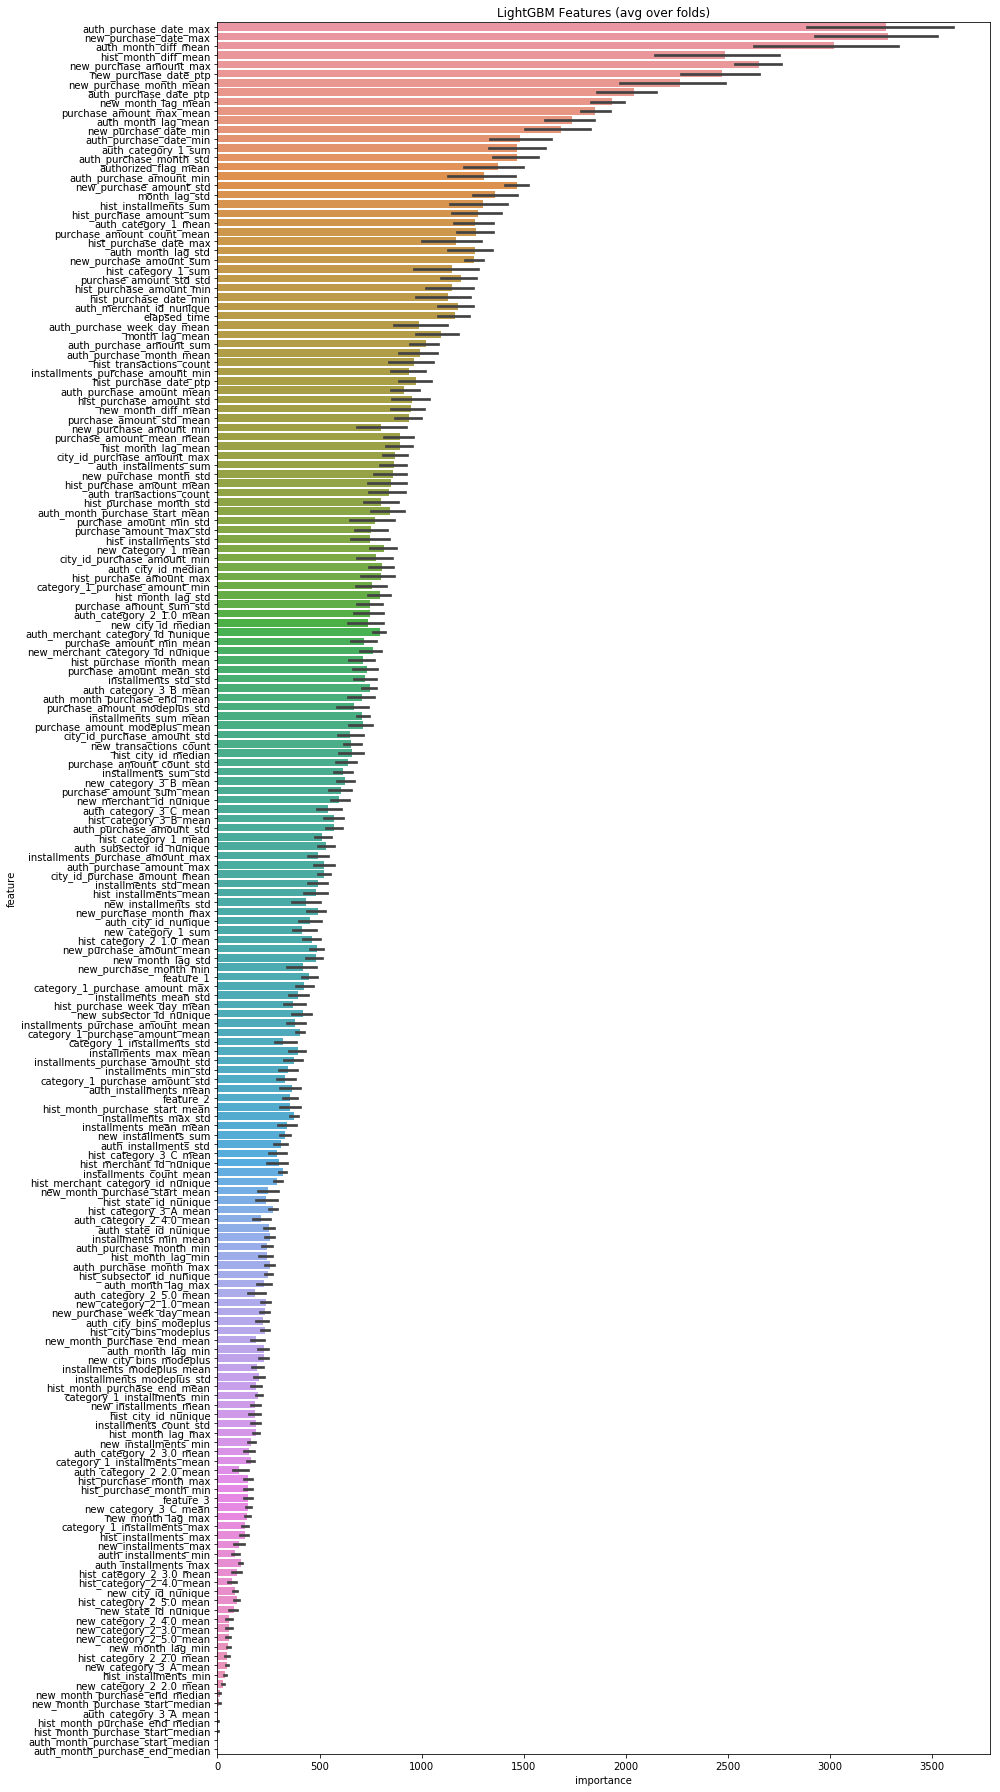

In [33]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [34]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)